# Tutorial 5 : Splines and DeBoor Cox algorithm

In this lab session, we are going to plot a 2D B-spline curve using the deBoor-Cox algorithm.

## Spline curve
The B-spline $S(t)$ of degree $k$ associated to the nodes $t_0 = \cdots = t_{k} < t_{k+1} < \cdots < t_N < t_{N+1} = \cdots = t_{N+k+1}$  and to the control polygon $[D] = [D_0...D_N]$, then the B-spline writes 
$$
S(t) = \sum_{i=0}^{N} D_i \, N_i^k(t), \quad t \in [t_{k},t_{N+1}] \quad \hbox{(1)}.
$$
In the above formulation $N_i^k$ are piecewise polynomials defined by, 
$$
\forall i\in\{0,\cdots,N+k\}\quad N_i^0(t) = \left\{\begin{array}{l}1\quad for\quad t\in [t_i,t_{i+1}[\\0\quad otherwise\\ \end{array}\right.
$$

For $l\geq 1$, we define 
$$
N_i^l(t) = \frac{t-t_i}{t_{i+k}-t_i}N_i^{l-1}(t) + \frac{t_{i+l+1}-t}{t_{i+k+1}-t_{i+1}}N_{i+1}^{l-1}(t)
$$
with the convention $0/0=0$
## DeBoor-Cox algorithm
The DeBoor-Cox algorithm is a triangular scheme that allows to calculate  $S(t)$  for $t \in [t_k, t_{N+1}]$. The algorithm works as follows.

1. Determine $r$ such that $t_r \leq  t < t_{r+1}$
2. Initialisation: $D^0_{i}=D_i$ for $i\in\{r-k,\cdots,r\}$
3. For $j = 1$ to $k$:

   For $i=r-k+j$ to $r$:

$$\displaystyle{D^j_i := {(t-t_i) * D_{i}^{j-1} + (t_{i+k-j+1}-t) * D_{i-1}^{j-1} \over t_{i+k-j+1}-t_i}}$$

Return: $S(t) := D^{k}_r$

# Questions 
1. write a function that that associates to $k$ a set of nodes $(t_i)$.
2. Write a function that evaluate the spline $S$, by using the definition in Equation (1) above.
3. Write a function that associates to $k$, $[D]$ and a parameter $t$, the evaluation $S(t)$ (using the DeBoor-Cox algorithm).
4.  plot several splines curves for diffent values of $k$. What do you observe ?

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt



## Question 1

 write a function that that associates to $k$ a set of nodes $(t_i)$.


In [2]:
def generate_knots(k, N):
    
    num_knots = N + k + 2
    num_interior = N - k
     
    knots = np.zeros(num_knots)
    
    if num_interior > 0:
        for j in range(1, num_interior + 1):
            knots[k + j] = j / (num_interior + 1)
    
    knots[N+1:] = 1.0
    
    return knots

## Question 2
Write a function that evaluate the spline $S$, by using the definition in Equation (1) above.


In [3]:
def basis_function(i, k, t, knots):
    if k == 0:
        if knots[i] <= t < knots[i+1]:
            return 1.0
        else:
            return 0.0
    
    denom1 = knots[i+k] - knots[i]
    if denom1 == 0:
        term1 = 0.0
    else:
        term1 = (t - knots[i]) / denom1 * basis_function(i, k-1, t, knots)
    
    denom2 = knots[i+k+1] - knots[i+1]
    if denom2 == 0:
        term2 = 0.0
    else:
        term2 = (knots[i+k+1] - t) / denom2 * basis_function(i+1, k-1, t, knots)
    
    return term1 + term2


def evaluate_bspline(t, control_points, k, knots):
    N = control_points.shape[1] - 1
    d = control_points.shape[0]
    
    if t == knots[N+1]:
        t = t - 1e-10
    
    point = np.zeros(d)
    
    for i in range(N + 1):
        basis = basis_function(i, k, t, knots)
        point += basis * control_points[:, i]
    
    return point

## Question 3
Write a function that evaluates $S(t)$ using the DeBoor-Cox algorithm.

In [4]:
def deboor_cox(t, control_points, k, knots):
  
    N = control_points.shape[1] - 1
    d = control_points.shape[0]
    
    r = None
    for i in range(len(knots) - 1):
        if knots[i] <= t < knots[i+1]:
            r = i
            break
    
    if t == knots[N+1]:
        r = N
    
    if r is None:
        raise ValueError(f"t={t} is outside the valid range [{knots[k]}, {knots[N+1]}]")
    
    D = np.zeros((d, k + 1))
    for idx, i in enumerate(range(r - k, r + 1)):
        if 0 <= i <= N:
            D[:, idx] = control_points[:, i]
    
    for j in range(1, k + 1):
        for idx in range(k - j + 1):
            i = r - k + j + idx  
            
            # Compute weight
            denom = knots[i + k - j + 1] - knots[i]
            if denom == 0:
                alpha = 0
            else:
                alpha = (t - knots[i]) / denom
            
            D[:, idx] = (1 - alpha) * D[:, idx] + alpha * D[:, idx + 1]
    
    return D[:, 0]


## Question 4
Plot several B-spline curves for different values of $k$. What do you observe?

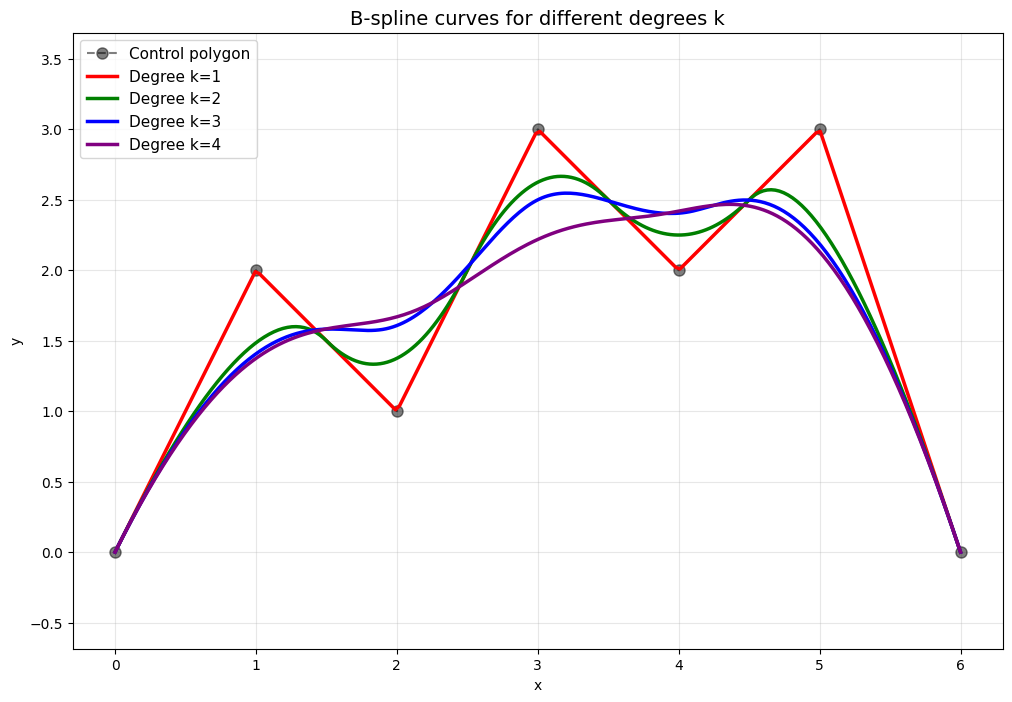

In [5]:

N = 6  # 7 control points
control_points = np.array([[0, 1, 2, 3, 4, 5, 6],
                           [0, 2, 1, 3, 2, 3, 0]], dtype=float)

degrees = [1, 2, 3, 4]
colors = ['red', 'green', 'blue', 'purple']

plt.figure(figsize=(12, 8))

plt.plot(control_points[0, :], control_points[1, :], 'ko--', 
         label='Control polygon', markersize=8, linewidth=1.5, alpha=0.5)

for k, color in zip(degrees, colors):
    knots = generate_knots(k, N)
    
    t_values = np.linspace(knots[k], knots[N+1], 200)
    curve = np.array([evaluate_bspline(t, control_points, k, knots) for t in t_values]).T
    
    plt.plot(curve[0, :], curve[1, :], color=color, linewidth=2.5, 
             label=f'Degree k={k}')

plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.axis('equal')
plt.title('B-spline curves for different degrees k', fontsize=14)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
